In [9]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.io import arff
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load data from file
eeg_data = arff.loadarff("/Users/sjw19206/7135CEM/eye-state-classification-dataset/EEG_Eye_State.arff")
# load data into dataframe
eeg_df = pd.DataFrame(eeg_data[0])
# rename column
eeg_df = eeg_df.rename(columns={"eyeDetection":"EYEST"})
# display first five rows
eeg_df.head(5)

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,EYEST
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'


In [3]:
# converting type of 'EYEST' - byte to integer
eeg_df_iv = eeg_df.drop('EYEST', axis = 1)
eeg_df_tv = eeg_df['EYEST'].astype(int)
eeg_df_upd = pd.concat([eeg_df_iv, eeg_df_tv], axis = 1)

In [4]:
# detect and remove outliers
z_scores = stats.zscore(eeg_df_upd)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 5).all(axis=1)
eeg_df_ro = eeg_df_upd[filtered_entries]
# reset index
eeg_df_ro = eeg_df_ro.reset_index(drop=True)

In [5]:
# we choose 120 window size to reduce data fluctuations
window_size = 120

# applying moving average
eeg_df_pma = eeg_df_ro.copy()
eeg_df_ma = eeg_df_ro.copy()
for f in eeg_df_ro.columns[:-1]:
    eeg_df_ma[f] = eeg_df_pma[f].rolling(window=window_size, center=False).mean()

In [6]:
eeg_df_ma.isnull().values.any()

True

In [7]:
# drop NaN
eeg_df_ma = eeg_df_ma.dropna()
eeg_df_ma = eeg_df_ma.reset_index(drop=True)
print(eeg_df_ro.shape)
print(eeg_df_ma.shape)

(14976, 15)
(14857, 15)


In [10]:
min_max_scaler = MinMaxScaler()
eeg_df_iv = eeg_df_ma.drop('EYEST', axis = 1)
eeg_df_tv = eeg_df_ma['EYEST']
eeg_df_scaled = min_max_scaler.fit_transform(eeg_df_iv.to_numpy())
eeg_df_scaled = pd.DataFrame(eeg_df_scaled, columns=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'])
eeg_df_scaled = pd.concat([eeg_df_scaled, eeg_df_tv], axis = 1)
eeg_df_scaled.head(5)

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,EYEST
0,0.490475,0.418271,0.318758,0.360048,0.183500,0.118699,0.445689,0.261206,0.270500,0.313864,0.417336,0.320584,0.532195,0.579140,0
1,0.489677,0.418033,0.317462,0.358350,0.183461,0.119844,0.445423,0.260338,0.269485,0.313744,0.417965,0.321201,0.531864,0.578103,0
2,0.489240,0.417944,0.316102,0.356582,0.183693,0.121245,0.445081,0.259659,0.269711,0.314646,0.418856,0.322187,0.531864,0.577616,0
3,0.488393,0.417855,0.314450,0.354177,0.184274,0.122561,0.444474,0.259546,0.270689,0.315999,0.419747,0.322773,0.532001,0.577045,0
4,0.487037,0.417292,0.312216,0.351560,0.184429,0.123591,0.443714,0.259093,0.270087,0.315788,0.420009,0.322496,0.531650,0.575860,0


In [11]:
# Split data 80% for training 20% for testing 
x_train, x_test, y_train, y_test = train_test_split(eeg_df_scaled[eeg_df_scaled.columns[:-1]], eeg_df_scaled['EYEST'],
                                                        test_size=0.20, shuffle=False)

In [12]:
# Train data
print('x_train length:', len(x_train))
print('y_train length:', len(y_train))
print()
# Test/Validation data
print('x_test length:', len(x_test))
print('y_test length:', len(y_test))

x_train length: 11885
y_train length: 11885

x_test length: 2972
y_test length: 2972


In [13]:
np_x_train = x_train.values 
np_y_train = y_train.values
np_x_test = x_test.values
np_y_test = y_test.values

In [14]:
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessClassifier

# model
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(np_x_train, np_y_train)

E:\Programs\ProgramFiles\anaconda3\envs\edsPyR\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [15]:
prediction = gpc.predict(np_x_test)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy : ', accuracy_score(np_y_test, prediction))
print('Precision : ', precision_score(np_y_test, prediction))
print('Recall : ', recall_score(np_y_test, prediction))
print('F1-score : ', f1_score(np_y_test, prediction))

Accuracy :  0.8879542395693136
Precision :  0.32242990654205606
Recall :  0.26848249027237353
F1-score :  0.2929936305732484


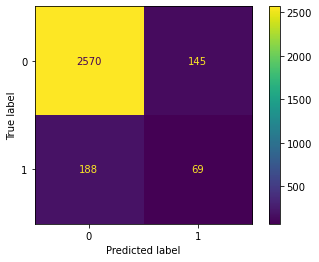

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(np_y_test, prediction)
cm = confusion_matrix(np_y_test, prediction, labels= gpc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=gpc.classes_)
disp.plot()
plt.show()